In [21]:
from test_cases import generate_meetingbank_comprehensiveness_benchmark


test_cases_gen = generate_meetingbank_comprehensiveness_benchmark(human_annotation_file_path="./datasets/meetingbank/human_scoring.json", meetingbank_file_path="/home/daniel/MeetingBank.json")
length = sum(1 for _ in test_cases_gen)
test_cases_gen = generate_meetingbank_comprehensiveness_benchmark(human_annotation_file_path="./datasets/meetingbank/human_scoring.json", meetingbank_file_path="/home/daniel/MeetingBank.json")


In [22]:
length

1400

In [23]:
comprehensiveness_golden_set = []
for i in range(length):
    comprehensiveness_golden_set.append(next(test_cases_gen))

assert(len(comprehensiveness_golden_set) == length)

In [24]:
comprehensiveness_golden_set[:3]

[{'query': "speaker 10: Is public comment next, Madam Clerk.\nspeaker 2: And item ten is next door to. Well.\nspeaker 10: That was pulled as well.\nspeaker 2: Item ten Report from Parks, Recreation and Marine and Financial Management Recommendation to authorize the city manager to execute three new permits to operate Kiteboarding and stand up paddle boarding. Stand Up Paddle Boarding. Rental and instruction concessions on City of Long Beach Beaches District three.\nspeaker 1: Can you turn this over to Councilman Price?\nspeaker 8: Thank you. So this has been an item that we've received a lot of inquiry about over the last couple of weeks, actually, several months. But really, the the item has ramped up the discussion. So with that, I'd like to see if Parks Rec and Marine has a report to share with us that hopefully incorporate some of the\nspeaker 8: concerns that have been raised.\nspeaker 3: I'd like to hand this over to L.V. to Halloran, our bureau manager for our Marine Bureau in t

In [25]:
import os
os.environ["OPENAI_API_KEY"] = "..." # for groundtruth feedback function


In [26]:
from trulens_eval import feedback
from trulens_eval.feedback import GroundTruthAgreement
from trulens_eval import Feedback, Select, Tru

import numpy as np


tru = Tru()

provider = feedback.OpenAI(model_engine="gpt-4-turbo-preview")

In [27]:
# comprehensiveness of summary with transcript as reference
f_comprehensiveness_openai = (
    Feedback(provider.comprehensiveness_with_cot_reasons)
    .on_input_output()
    .aggregate(np.mean)
)


✅ In comprehensiveness_with_cot_reasons, input source will be set to __record__.main_input or `Select.RecordInput` .
✅ In comprehensiveness_with_cot_reasons, input summary will be set to __record__.main_output or `Select.RecordOutput` .


In [28]:
# Create a Feedback object using the numeric_difference method of the ground_truth object
ground_truth = GroundTruthAgreement(comprehensiveness_golden_set)
# Call the numeric_difference method with app and record and aggregate to get the mean absolute error
f_mae = Feedback(ground_truth.mae, name = "Mean Absolute Error").on(Select.Record.calls[0].args.args[0]).on(Select.Record.calls[0].args.args[1]).on_output()

✅ In Mean Absolute Error, input prompt will be set to __record__.calls[0].args.args[0] .
✅ In Mean Absolute Error, input response will be set to __record__.calls[0].args.args[1] .
✅ In Mean Absolute Error, input score will be set to __record__.main_output or `Select.RecordOutput` .


In [29]:
from benchmark_frameworks.eval_as_recommendation import compute_ndcg, compute_ece, recall_at_k, precision_at_k

scores = []
true_scores = [] # human prefrences / scores

In [30]:
import time
import pandas as pd


for i in range(len(comprehensiveness_golden_set)):
    # if i % 3 == 0: # sample 33% out of 1400 test cases
        # start_time = time.time()
    source = comprehensiveness_golden_set[i]["query"]
    summary = comprehensiveness_golden_set[i]["response"]
    expected_score = comprehensiveness_golden_set[i]["expected_score"]
    feedback_score = f_comprehensiveness_openai(source, summary)[0]

    scores.append(feedback_score)
    true_scores.append(expected_score)

    end_time = time.time()
    # print(f"LLM run takes {end_time - start_time} seconds")
    # time.sleep(1)

    if i % 200 == 0:
        df_results = pd.DataFrame({'scores': scores, 'true_scores': true_scores})

        # Save the DataFrame to a CSV file
        df_results.to_csv('results_gainsight.csv', index=False)


   

In [31]:

len(true_scores)

1400

In [32]:
ece = compute_ece([scores], [true_scores], n_bins=10) # ECE might not make much sense here as we have groundtruth in numeric values

mae = sum(abs(score - true_score) for score, true_score in zip(scores, true_scores)) / len(scores)


In [33]:
print(f"ECE: {ece}; MAE: {mae}")

ECE: 0.2151285714285715; MAE: 0.2493357142857129


In [34]:
len(true_scores)

1400

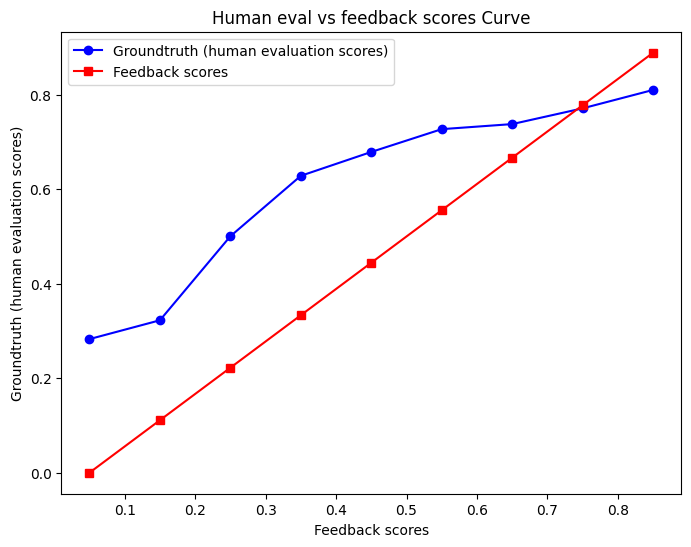

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming scores and true_scores are flat lists of predicted probabilities and their corresponding ground truth relevances
scores_np = np.array(scores)
true_scores_np = np.array(true_scores)

# Normalize scores to be in the range [0, 1]
scores_normalized = (scores_np - scores_np.min()) / (scores_np.max() - scores_np.min())

n_bins = 10
bin_limits = np.linspace(0, 1, n_bins + 1)
bin_centers = (bin_limits[:-1] + bin_limits[1:]) / 2
accuracies = []
confidences = []

for i in range(n_bins):
    in_bin = (scores_normalized >= bin_limits[i]) & (scores_normalized < bin_limits[i+1])
    if in_bin.any():
        accuracies.append(np.mean(true_scores_np[in_bin]))
        confidences.append(np.mean(scores_normalized[in_bin]))
    else:
        accuracies.append(None)
        confidences.append(None)

plt.figure(figsize=(8, 6))
plt.plot(bin_centers, accuracies, marker='o', linestyle='-', color='blue', label='Groundtruth (human evaluation scores)')
plt.plot(bin_centers, confidences, marker='s', linestyle='-', color='red', label='Feedback scores')
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Feedback scores')
plt.ylabel('Groundtruth (human evaluation scores)')
plt.title('Human eval vs feedback scores Curve')
plt.legend()
plt.show()


In [50]:
true_scores

[0.8,
 0.67,
 0.53,
 0.2,
 0.73,
 0.4,
 0.87,
 0.47,
 0.4,
 0.93,
 0.6,
 0.93,
 0.2,
 0.6,
 0.6,
 0.6,
 0.2,
 0.6,
 0.67,
 0.4,
 0.33,
 0.87,
 0.2,
 0.93,
 0.8,
 0.53,
 0.8,
 0.67,
 0.47,
 0.47,
 0.47,
 0.2,
 0.2,
 0.73,
 0.6,
 0.8,
 0.53,
 0.4,
 0.93,
 0.2,
 0.53,
 0.53,
 0.4,
 0.6,
 0.53,
 0.67,
 0.47,
 0.73,
 0.2,
 0.47,
 0.8,
 0.73,
 0.67,
 0.8,
 0.8,
 0.27,
 0.6,
 0.67,
 0.87,
 0.47,
 0.73,
 0.8,
 0.2,
 0.2,
 0.6,
 0.73,
 0.67,
 0.4,
 0.2,
 0.67,
 0.2,
 0.53,
 0.8,
 0.87,
 0.6,
 0.87,
 0.87,
 0.87,
 0.2,
 0.87,
 0.6,
 0.8,
 0.6,
 0.67,
 0.73,
 0.2,
 0.73,
 0.73,
 0.87,
 0.27,
 0.6,
 0.27,
 0.73,
 0.47,
 0.8,
 0.6,
 0.73,
 0.93,
 0.2,
 0.6,
 0.2,
 0.93,
 0.53,
 0.67,
 0.67,
 0.6,
 0.53,
 0.2,
 0.33,
 0.2,
 0.6,
 0.4,
 0.2,
 0.6,
 0.67,
 0.27,
 0.73,
 0.2,
 0.27,
 0.87,
 0.73,
 0.47,
 0.6,
 0.2,
 0.8,
 0.2,
 0.6,
 0.67,
 0.27,
 0.2,
 0.2,
 0.67,
 0.53,
 0.33,
 0.8,
 0.53,
 0.67,
 0.2,
 0.33,
 0.4,
 0.93,
 0.87,
 0.6,
 0.73,
 0.4,
 0.87,
 0.6,
 0.93,
 0.53,
 0.6,
 0.2,
 0.87,
 0.87,


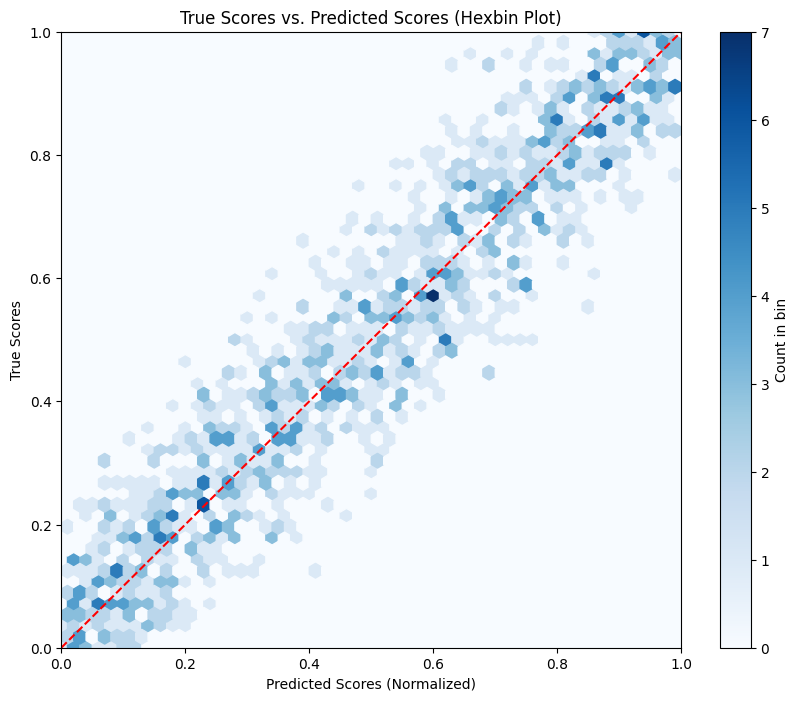

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Example data generation (replace with your actual data)
np.random.seed(42)  # For reproducibility
scores = np.random.uniform(low=0.0, high=1.0, size=1400)
true_scores = scores + np.random.normal(loc=0.0, scale=0.1, size=1400)

# Normalize the predicted scores to the range [0, 1]
scores_normalized = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))

# Hexbin plot
plt.figure(figsize=(10, 8))
plt.hexbin(scores_normalized, true_scores, gridsize=50, cmap='Blues', extent=(0, 1, 0, 1))
plt.colorbar(label='Count in bin')
plt.plot([0, 1], [0, 1], 'r--')  # Ideal fit line
plt.title('True Scores vs. Predicted Scores (Hexbin Plot)')
plt.xlabel('Predicted Scores (Normalized)')
plt.ylabel('True Scores')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


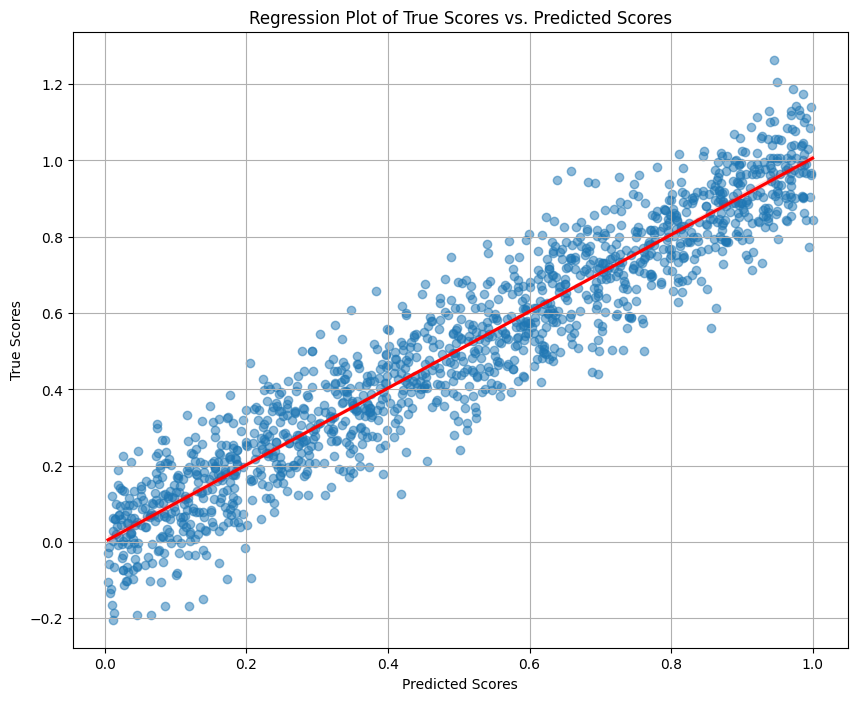

In [56]:
import seaborn as sns

# Assume scores_normalized and true_scores represent your dataset
np.random.seed(42)  # Ensuring reproducibility
scores = np.random.uniform(low=0, high=1, size=1400)
true_scores = scores + np.random.normal(loc=0, scale=0.1, size=1400)  # Adding some noise

# Plotting the regression graph using seaborn
plt.figure(figsize=(10, 8))
sns.regplot(x=scores, y=true_scores, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Regression Plot of True Scores vs. Predicted Scores')
plt.xlabel('Predicted Scores')
plt.ylabel('True Scores')
plt.grid(True)
plt.show()